## **Importing Necessary Libraries**

In [ ]:
pip install jugaad-data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 6.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## **Data Scraping**

In [ ]:
from datetime import date
from jugaad_data.nse import bhavcopy_save, bhavcopy_fo_save

# Download bhavcopy
bhavcopy_save(date(2018,1,1), "/content/sample_data")

# Download bhavcopy for futures and options
bhavcopy_fo_save(date(2018,1,1), "/content/sample_data")

# Download stock data to pandas dataframe
from jugaad_data.nse import stock_df
df_SBIN = stock_df(symbol="SBIN", from_date=date(2018,1,1),
            to_date=date(2022,5,16), series="EQ")
df_TATA = stock_df(symbol="TATASTEEL", from_date=date(2018,1,1),
            to_date=date(2022,5,16), series="EQ")
df_RELIANCE = stock_df(symbol="RELIANCE", from_date=date(2018,1,1),
            to_date=date(2022,5,16), series="EQ")
df_WIPRO = stock_df(symbol="WIPRO", from_date=date(2018,1,1),
            to_date=date(2022,5,16), series="EQ")
df_TCS = stock_df(symbol="TCS", from_date=date(2018,1,1),
            to_date=date(2022,5,16), series="EQ")
df1 = df_SBIN.to_csv('SBIN_Data.csv')
df2 = df_TATA.to_csv('TATA_Data.csv')
df3 = df_RELIANCE.to_csv('RELIANCE_Data.csv')
df4 = df_WIPRO.to_csv('WIPRO_Data.csv')
df5 = df_TCS.to_csv('TCS_Data.csv')

In [ ]:
SBI = pd.read_csv("SBIN_Data.csv")
TATA = pd.read_csv("TATA_Data.csv")
RELIANCE = pd.read_csv("RELIANCE_Data.csv")
TCS = pd.read_csv("TCS_Data.csv")
WIPRO = pd.read_csv("WIPRO_Data.csv")

## **Model Building with UDF**

In [ ]:
def Dataset(Data, Date):

  Train_Data = Data['VWAP'][Data['DATE'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['VWAP'][Data['DATE'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [ ]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [ ]:
model = Model()

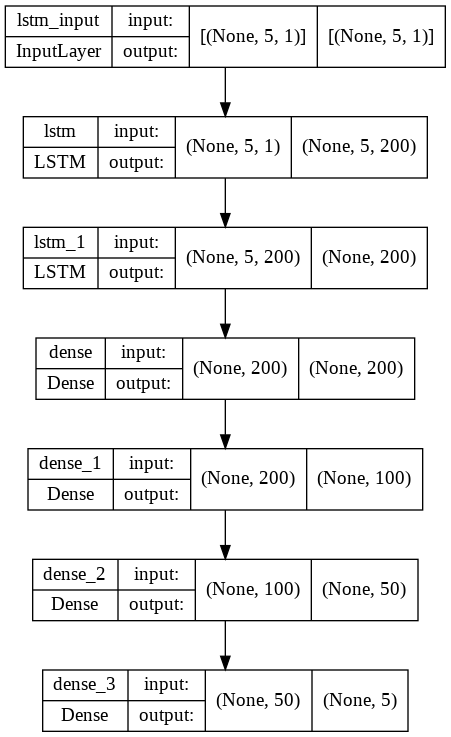

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548,005
Trainable params: 548,005
Non-trai

### Custom Learning Rate

In [ ]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#SBI

In [ ]:
SBI.shape

(1081, 16)

In [ ]:
SBI.columns

Index(['Unnamed: 0', 'DATE', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE',
       'LTP', 'CLOSE', 'VWAP', '52W H', '52W L', 'VOLUME', 'VALUE',
       'NO OF TRADES', 'SYMBOL'],
      dtype='object')

In [ ]:
SBI = SBI.drop(columns=['Unnamed: 0','SERIES','PREV. CLOSE','52W H','52W L','SYMBOL'])

In [ ]:
SBI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1081 non-null   object 
 1   OPEN          1081 non-null   float64
 2   HIGH          1081 non-null   float64
 3   LOW           1081 non-null   float64
 4   LTP           1081 non-null   float64
 5   CLOSE         1081 non-null   float64
 6   VWAP          1081 non-null   float64
 7   VOLUME        1081 non-null   int64  
 8   VALUE         1081 non-null   float64
 9   NO OF TRADES  1081 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 84.6+ KB


In [ ]:
SBI.head()

,DATE,OPEN,HIGH,LOW,LTP,CLOSE,VWAP,VOLUME,VALUE,NO OF TRADES
0,2022-05-16,445.00,461.50,438.85,456.0,455.00,454.93,27940958,1.271105e+10,283950
1,2022-05-13,469.45,477.00,439.75,440.5,444.65,461.88,61403008,2.836053e+10,595336
2,2022-05-12,473.00,473.00,456.35,462.7,462.65,462.77,18947096,8.768076e+09,314035
3,2022-05-11,475.25,479.00,463.65,478.4,476.55,471.45,14771351,6.963938e+09,241751
4,2022-05-10,477.00,482.55,473.50,474.0,475.20,477.99,10884328,5.202612e+09,183663


In [ ]:
# Change Dtype of Date column
SBI["DATE"] = pd.to_datetime(SBI["DATE"])

###Split the Data into Training and Test set
    Training Period: 2018-01-01 - 2020-09-30

    Testing Period:  2020-10-01 - 2022-05-17

In [ ]:
SBI_Date = '2020-10-01'
SBI_Train_X, SBI_Train_Y, SBI_Test_X, SBI_Test_Y = Dataset(SBI, SBI_Date)

### Model Fitting

In [ ]:
SBI_Model = Model()

In [ ]:
SBI_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
SBI_hist = SBI_Model.fit(SBI_Train_X, SBI_Train_Y, epochs = 200, validation_data = (SBI_Test_X, SBI_Test_Y), callbacks=[callback])

Epoch 1/200
5/5 [==============================] - 3s 187ms/step - loss: 77387.2969 - root_mean_squared_error: 278.1857 - val_loss: 173282.2812 - val_root_mean_squared_error: 416.2719 - lr: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 0s 37ms/step - loss: 77387.1875 - root_mean_squared_error: 278.1855 - val_loss: 173281.9062 - val_root_mean_squared_error: 416.2714 - lr: 6.6667e-08
Epoch 3/200
5/5 [==============================] - 0s 41ms/step - loss: 77386.6953 - root_mean_squared_error: 278.1847 - val_loss: 173281.1562 - val_root_mean_squared_error: 416.2705 - lr: 1.3333e-07
Epoch 4/200
5/5 [==============================] - 0s 41ms/step - loss: 77385.8359 - root_mean_squared_error: 278.1831 - val_loss: 173279.9219 - val_root_mean_squared_error: 416.2690 - lr: 2.0000e-07
Epoch 5/200
5/5 [==============================] - 0s 42ms/step - loss: 77384.6094 - root_mean_squared_error: 278.1809 - val_loss: 173278.2812 - val_root_mean_squared_error: 416.2671 - lr: 2.6667e-07

In [ ]:
history_dict = SBI_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

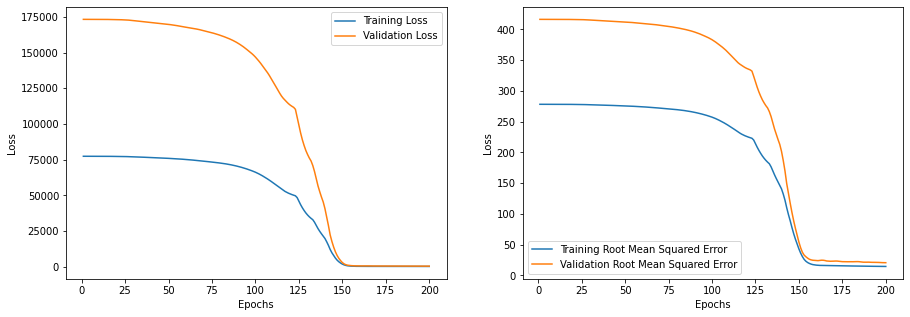

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of SBI

In [ ]:
SBI_prediction = SBI_Model.predict(SBI_Test_X)

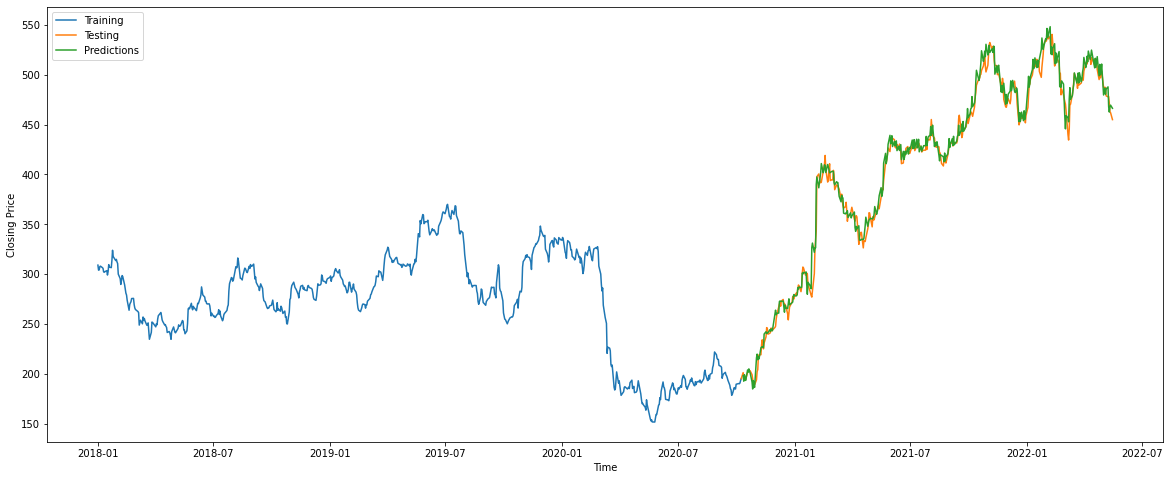

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(SBI['DATE'][SBI['DATE'] < '2020-10-12'], SBI['VWAP'][SBI['DATE'] < '2020-10-12'], label = 'Training')
plt.plot(SBI['DATE'][SBI['DATE'] >= '2020-10-09'], SBI['VWAP'][SBI['DATE'] >= '2020-10-09'], label = 'Testing')
plt.plot(SBI['DATE'][SBI['DATE'] >= '2020-10-12'], SBI_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(SBI_Test_Y.reshape(-1, 5), SBI_prediction))
mape = np.mean(np.abs(SBI_prediction - SBI_Test_Y.reshape(-1, 5))/np.abs(SBI_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 20.650508361965503
MAPE: 0.0415961714833739


#TATA

In [ ]:
TATA.head()

,Unnamed: 0,DATE,SERIES,OPEN,HIGH,LOW,PREV. CLOSE,LTP,CLOSE,VWAP,52W H,52W L,VOLUME,VALUE,NO OF TRADES,SYMBOL
0,0,2022-05-16,EQ,1119.0,1134.80,1094.00,1097.00,1109.00,1103.5,1113.49,1534.5,1050.25,6266527,6.977733e+09,166059,TATASTEEL
1,1,2022-05-13,EQ,1135.0,1151.80,1092.00,1117.70,1094.85,1097.0,1121.87,1534.5,1050.25,8292441,9.303075e+09,216773,TATASTEEL
2,2,2022-05-12,EQ,1156.9,1162.40,1103.00,1165.70,1118.90,1117.7,1123.94,1534.5,1050.25,9419161,1.058661e+10,258893,TATASTEEL
3,3,2022-05-11,EQ,1175.0,1190.90,1123.40,1164.90,1172.90,1165.7,1156.89,1534.5,1050.25,10706315,1.238605e+10,243457,TATASTEEL
4,4,2022-05-10,EQ,1251.0,1254.65,1158.55,1252.25,1161.25,1164.9,1196.85,1534.5,1050.25,14553742,1.741867e+10,344143,TATASTEEL


In [ ]:
TATA = TATA.drop(columns=['Unnamed: 0','SERIES','PREV. CLOSE','52W H','52W L','SYMBOL'])

In [ ]:
TATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1081 non-null   object 
 1   OPEN          1081 non-null   float64
 2   HIGH          1081 non-null   float64
 3   LOW           1081 non-null   float64
 4   LTP           1081 non-null   float64
 5   CLOSE         1081 non-null   float64
 6   VWAP          1081 non-null   float64
 7   VOLUME        1081 non-null   int64  
 8   VALUE         1081 non-null   float64
 9   NO OF TRADES  1081 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 84.6+ KB


In [ ]:
# Change Dtype of Date column
TATA["DATE"] = pd.to_datetime(TATA["DATE"])

###Split the Data into Training and Test set
    Training Period: 2018-01-01 - 2020-09-30

    Testing Period:  2020-10-01 - 2022-05-17

In [ ]:
TATA_Date = '2020-10-01'
TATA_Train_X, TATA_Train_Y, TATA_Test_X, TATA_Test_Y = Dataset(TATA, TATA_Date)

### Model Fitting

In [ ]:
TATA_Model = Model()

In [ ]:
TATA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
TATA_hist = TATA_Model.fit(TATA_Train_X, TATA_Train_Y, epochs = 200, validation_data = (TATA_Test_X, TATA_Test_Y), callbacks=[callback])

Epoch 1/200
5/5 [==============================] - 3s 131ms/step - loss: 242939.5000 - root_mean_squared_error: 492.8889 - val_loss: 1155164.3750 - val_root_mean_squared_error: 1074.7858 - lr: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 0s 39ms/step - loss: 242937.5000 - root_mean_squared_error: 492.8869 - val_loss: 1155155.5000 - val_root_mean_squared_error: 1074.7816 - lr: 6.6667e-08
Epoch 3/200
5/5 [==============================] - 0s 38ms/step - loss: 242929.3750 - root_mean_squared_error: 492.8787 - val_loss: 1155138.0000 - val_root_mean_squared_error: 1074.7734 - lr: 1.3333e-07
Epoch 4/200
5/5 [==============================] - 0s 40ms/step - loss: 242914.6562 - root_mean_squared_error: 492.8637 - val_loss: 1155113.8750 - val_root_mean_squared_error: 1074.7623 - lr: 2.0000e-07
Epoch 5/200
5/5 [==============================] - 0s 38ms/step - loss: 242893.3594 - root_mean_squared_error: 492.8421 - val_loss: 1155080.2500 - val_root_mean_squared_error: 1074.7466 -

In [ ]:
history_dict = TATA_hist.history
loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

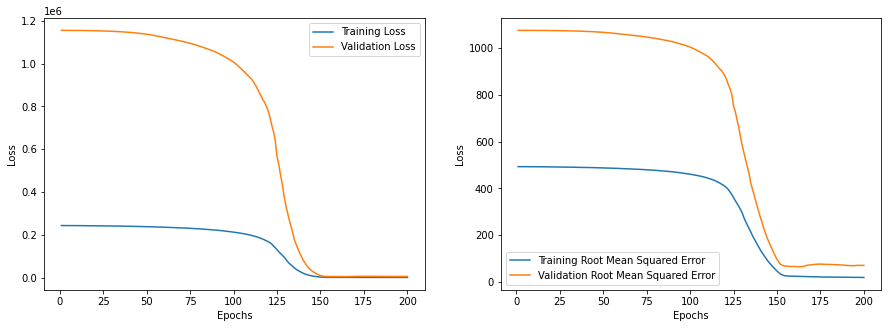

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of TATA

In [ ]:
TATA_prediction = TATA_Model.predict(TATA_Test_X)

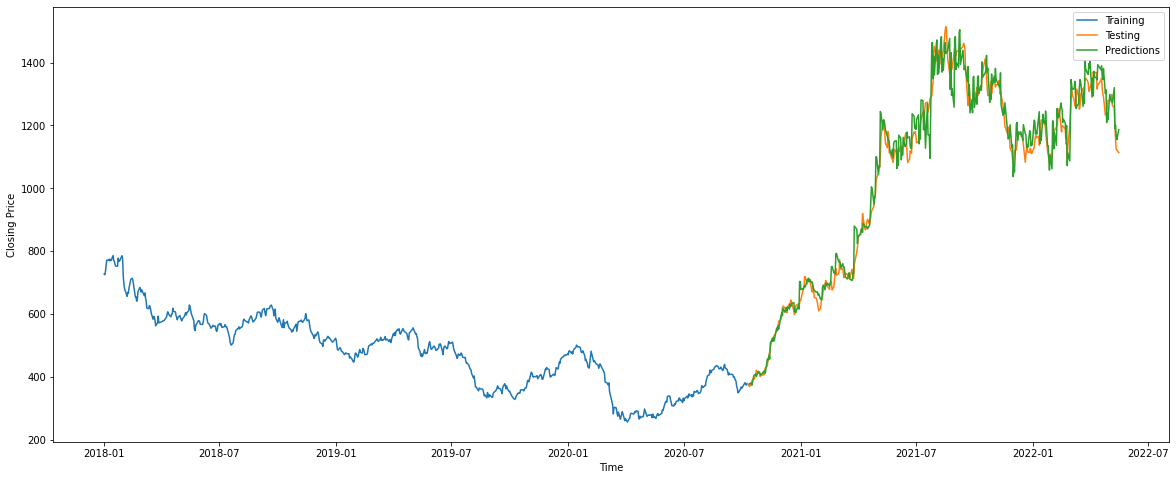

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(TATA['DATE'][TATA['DATE'] < '2020-10-12'], TATA['VWAP'][TATA['DATE'] < '2020-10-12'], label = 'Training')
plt.plot(TATA['DATE'][TATA['DATE'] >= '2020-10-09'], TATA['VWAP'][TATA['DATE'] >= '2020-10-09'], label = 'Testing')
plt.plot(TATA['DATE'][TATA['DATE'] >= '2020-10-12'], TATA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(TATA_Test_Y.reshape(-1, 5), TATA_prediction))
mape = np.mean(np.abs(TATA_prediction - TATA_Test_Y.reshape(-1, 5))/np.abs(TATA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 71.39369486157453
MAPE: 0.05502125818917773


#Reliance

In [ ]:
RELIANCE.head()

,Unnamed: 0,DATE,SERIES,OPEN,HIGH,LOW,PREV. CLOSE,LTP,CLOSE,VWAP,52W H,52W L,VOLUME,VALUE,NO OF TRADES,SYMBOL
0,0,2022-05-16,EQ,2434.45,2481.00,2416.65,2426.60,2428.05,2427.20,2444.28,2856.15,1930.4,6201594,1.515841e+10,244925,RELIANCE
1,1,2022-05-13,EQ,2426.00,2478.00,2415.35,2399.40,2431.45,2426.60,2451.67,2856.15,1906.0,8910998,2.184680e+10,408746,RELIANCE
2,2,2022-05-12,EQ,2427.50,2434.85,2370.00,2449.30,2403.50,2399.40,2400.60,2856.15,1906.0,9456280,2.270075e+10,359540,RELIANCE
3,3,2022-05-11,EQ,2472.65,2484.95,2421.95,2474.65,2450.75,2449.30,2454.29,2856.15,1906.0,7681157,1.885176e+10,325039,RELIANCE
4,4,2022-05-10,EQ,2495.00,2526.60,2458.00,2518.30,2461.70,2474.65,2495.14,2856.15,1906.0,9004636,2.246785e+10,329083,RELIANCE


In [ ]:
RELIANCE = RELIANCE.drop(columns=['Unnamed: 0','SERIES','PREV. CLOSE','52W H','52W L','SYMBOL'])

In [ ]:
RELIANCE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1081 non-null   object 
 1   OPEN          1081 non-null   float64
 2   HIGH          1081 non-null   float64
 3   LOW           1081 non-null   float64
 4   LTP           1081 non-null   float64
 5   CLOSE         1081 non-null   float64
 6   VWAP          1081 non-null   float64
 7   VOLUME        1081 non-null   int64  
 8   VALUE         1081 non-null   float64
 9   NO OF TRADES  1081 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 84.6+ KB


In [ ]:
# Change Dtype of Date column
RELIANCE["DATE"] = pd.to_datetime(RELIANCE["DATE"])

###Split the Data into Training and Test set
    Training Period: 2018-01-01 - 2020-09-30

    Testing Period:  2020-10-01 - 2022-05-17

In [ ]:
RELIANCE_Date = '2020-11-01'
RELIANCE_Train_X, RELIANCE_Train_Y, RELIANCE_Test_X, RELIANCE_Test_Y = Dataset(RELIANCE, RELIANCE_Date)

### Model Fitting

In [ ]:
RELIANCE_Model = Model()

In [ ]:
RELIANCE_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
RELIANCE_hist = RELIANCE_Model.fit(RELIANCE_Train_X, RELIANCE_Train_Y, epochs = 200, validation_data = (RELIANCE_Test_X, RELIANCE_Test_Y), callbacks = [callback])

Epoch 1/200
5/5 [==============================] - 3s 186ms/step - loss: 1868723.5000 - root_mean_squared_error: 1367.0127 - val_loss: 5025701.0000 - val_root_mean_squared_error: 2241.8076 - lr: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 0s 41ms/step - loss: 1868698.6250 - root_mean_squared_error: 1367.0035 - val_loss: 5025456.0000 - val_root_mean_squared_error: 2241.7529 - lr: 6.6667e-08
Epoch 3/200
5/5 [==============================] - 0s 40ms/step - loss: 1868605.6250 - root_mean_squared_error: 1366.9696 - val_loss: 5024895.5000 - val_root_mean_squared_error: 2241.6279 - lr: 1.3333e-07
Epoch 4/200
5/5 [==============================] - 0s 41ms/step - loss: 1868425.7500 - root_mean_squared_error: 1366.9037 - val_loss: 5024042.0000 - val_root_mean_squared_error: 2241.4373 - lr: 2.0000e-07
Epoch 5/200
5/5 [==============================] - 0s 40ms/step - loss: 1868179.5000 - root_mean_squared_error: 1366.8136 - val_loss: 5022822.5000 - val_root_mean_squared_error: 2

In [ ]:
history_dict = RELIANCE_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

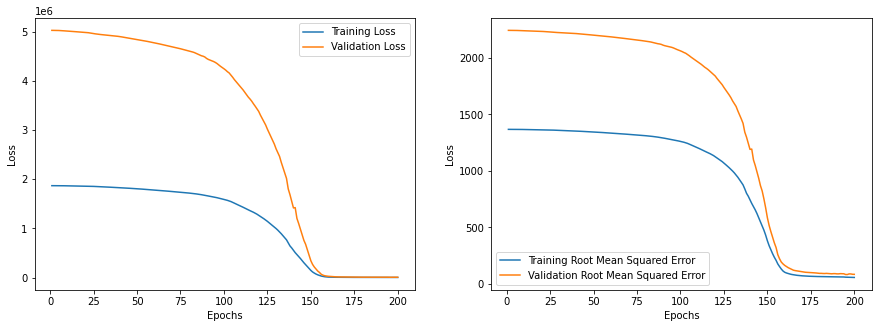

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Reliance

In [ ]:
RELIANCE_prediction = RELIANCE_Model.predict(RELIANCE_Test_X)

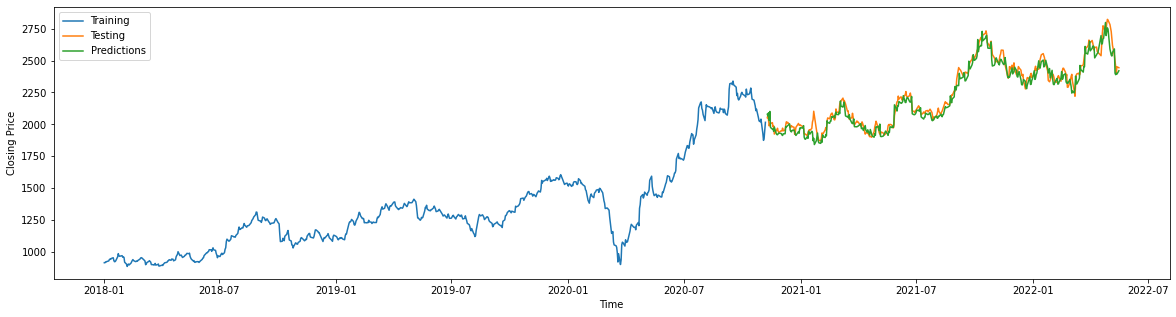

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(RELIANCE['DATE'][RELIANCE['DATE'] < '2020-11-07'], RELIANCE['VWAP'][RELIANCE['DATE'] < '2020-11-07'], label = 'Training')
plt.plot(RELIANCE['DATE'][RELIANCE['DATE'] >= '2020-11-07'], RELIANCE['VWAP'][RELIANCE['DATE'] >= '2020-11-07'], label = 'Testing')
plt.plot(RELIANCE['DATE'][RELIANCE['DATE'] >= '2020-11-07'], RELIANCE_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(RELIANCE_Test_Y.reshape(-1, 5), RELIANCE_prediction))
mape = np.mean(np.abs(RELIANCE_prediction - RELIANCE_Test_Y.reshape(-1, 5))/np.abs(RELIANCE_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 86.11948918337981
MAPE: 0.02845556873071148


#Wipro

In [ ]:
WIPRO.head()

,Unnamed: 0,DATE,SERIES,OPEN,HIGH,LOW,PREV. CLOSE,LTP,CLOSE,VWAP,52W H,52W L,VOLUME,VALUE,NO OF TRADES,SYMBOL
0,0,2022-05-16,EQ,474.00,474.35,465.00,468.65,468.80,468.00,468.95,739.85,462.15,3657033,1.714979e+09,92711,WIPRO
1,1,2022-05-13,EQ,479.50,479.50,467.00,473.80,468.80,468.65,472.26,739.85,462.15,8387659,3.961189e+09,203118,WIPRO
2,2,2022-05-12,EQ,468.10,476.00,462.15,471.90,475.50,473.80,470.53,739.85,462.15,7286500,3.428524e+09,173792,WIPRO
3,3,2022-05-11,EQ,480.05,481.95,462.55,477.65,475.95,471.90,470.86,739.85,462.55,10514671,4.950967e+09,218374,WIPRO
4,4,2022-05-10,EQ,483.00,483.75,476.15,483.15,477.10,477.65,480.28,739.85,474.60,7484767,3.594800e+09,171652,WIPRO


In [ ]:
WIPRO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1081 non-null   int64  
 1   DATE          1081 non-null   object 
 2   SERIES        1081 non-null   object 
 3   OPEN          1081 non-null   float64
 4   HIGH          1081 non-null   float64
 5   LOW           1081 non-null   float64
 6   PREV. CLOSE   1081 non-null   float64
 7   LTP           1081 non-null   float64
 8   CLOSE         1081 non-null   float64
 9   VWAP          1081 non-null   float64
 10  52W H         1081 non-null   float64
 11  52W L         1081 non-null   float64
 12  VOLUME        1081 non-null   int64  
 13  VALUE         1081 non-null   float64
 14  NO OF TRADES  1081 non-null   int64  
 15  SYMBOL        1081 non-null   object 
dtypes: float64(10), int64(3), object(3)
memory usage: 135.2+ KB


In [ ]:
WIPRO = WIPRO.drop(columns=['Unnamed: 0','SERIES','PREV. CLOSE','52W H','52W L','SYMBOL'])

In [ ]:
# Change Dtype of Date column
WIPRO["DATE"] = pd.to_datetime(WIPRO["DATE"])

###Split the Data into Training and Test set
    Training Period: 2018-01-01 - 2020-09-30

    Testing Period:  2020-10-01 - 2022-05-17

In [ ]:
WIPRO_Date = '2020-10-01'
WIPRO_Train_X, WIPRO_Train_Y, WIPRO_Test_X, WIPRO_Test_Y = Dataset(WIPRO, WIPRO_Date)

### Model Fitting

In [ ]:
WIPRO_Model = Model()

In [ ]:
WIPRO_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
WIPRO_hist = WIPRO_Model.fit(WIPRO_Train_X, WIPRO_Train_Y, epochs = 1000, validation_data = (WIPRO_Test_X, WIPRO_Test_Y), callbacks=[callback])

In [ ]:
history_dict = WIPRO_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of WIPRO

In [ ]:
WIPRO_prediction = WIPRO_Model.predict(WIPRO_Test_X)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(WIPRO['DATE'][WIPRO['DATE'] < '2020-10-12'], WIPRO['VWAP'][WIPRO['DATE'] < '2020-10-12'], label = 'Training')
plt.plot(WIPRO['DATE'][WIPRO['DATE'] >= '2020-10-09'], WIPRO['VWAP'][WIPRO['DATE'] >= '2020-10-09'], label = 'Testing')
plt.plot(WIPRO['DATE'][WIPRO['DATE'] >= '2020-10-12'], WIPRO_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(WIPRO_Test_Y.reshape(-1, 5), WIPRO_prediction))
mape = np.mean(np.abs(WIPRO_prediction - WIPRO_Test_Y.reshape(-1, 5))/np.abs(WIPRO_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

#TCS

In [ ]:
TCS.head()

In [ ]:
TCS.info()

In [ ]:
# Change Dtype of Date column
TCS["DATE"] = pd.to_datetime(TCS["DATE"])

###Split the Data into Training and Test set
    Training Period: 2018-01-01 - 2020-09-30

    Testing Period:  2020-10-01 - 2022-05-17

In [ ]:
TCS_Date = '2020-11-01'
TCS_Train_X, TCS_Train_Y, TCS_Test_X, TCS_Test_Y = Dataset(TCS, TCS_Date)

### Model Fitting

In [ ]:
TCS_Model = Model()

In [ ]:
TCS_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
TCS_hist = TCS_Model.fit(TCS_Train_X, TCS_Train_Y, epochs = 200, validation_data = (TCS_Test_X, TCS_Test_Y), callbacks=[callback])

In [ ]:
history_dict = TCS_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of TCS

In [ ]:
TCS_prediction = TCS_Model.predict(TCS_Test_X)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(TCS['DATE'][TCS['DATE'] < '2020-11-07'], TCS['VWAP'][TCS['DATE'] < '2020-11-07'], label = 'Training')
plt.plot(TCS['DATE'][TCS['DATE'] >= '2020-11-07'], TCS['VWAP'][TCS['DATE'] >= '2020-11-07'], label = 'Testing')
plt.plot(TCS['DATE'][TCS['DATE'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(TCS_Test_Y.reshape(-1, 5), TCS_prediction))
mape = np.mean(np.abs(TCS_prediction - TCS_Test_Y.reshape(-1, 5))/np.abs(TCS_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')